# Naive Bayes Classification of Mushrooms

In this notebook, we take a dataset of mushroom features from kaggle and build a model that can classify a mushroom as either poisionous or edible depending on it's features using Naive Bayes Classification

In [50]:
from ipywidgets import interact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
plt.rcParams['figure.figsize'] = [12, 9]
from matplotlib import pyplot as plt

# Fraction reserved for training
TRAIN_FRAC = 0.75

Naive Bayes Classification takes advantage of Bayes' Theorem, a theorem that seems simple and intuitive but is nonetheless profound

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

You have an initial probability of some $A$ happening (the prior $P(A)$), and, as more evidence $B$ is uncovered, the known probability of $A$ is updated (the posterior $P(A|B)$). In this case, $A$ would be whether or not a mushroom is posionous. If the mushroom cap is colored red, for example, it might be more or less probable for the mushroom to be poisionous given this new information. This is determined by the likelihood $P(B|A)$ of a poisionous mushroom to be red.

As he usually does, [3Blue1Brown](https://youtu.be/HZGCoVF3YvM) explains this so much better. Check out his video.

So, we have a set of mushroom features $\textbf{x}$ and we formulate the probability of a mushroom being poisionous given the mushroom has these properties using Bayes' Theorem

$$
P(Poisionous | \textbf{x}) = \frac{P(\textbf{x} | Poisionous)P(Poisionous)}{P(\textbf{x})}
$$

The "naive" in Naive Bayes means we assume all features are independent of one another. This is not necessarily true, as features often appear together. Mushrooms are made up of discreet species which all exhibit the same set of properties. However, making this assumption allows this equation to be written out as a product of individual likelihoods

$$
P(Poisionous | \textbf{x}) = P(Poisionous) * P(x_1 | Poisionous) * P(x_2 | Poisionous) * P(x_3 | Poisionous) *\ ...\ * P(x_n | Poisionous)
$$

We likewise do the same for "Edible"

Since $P(\textbf{x})$ is a constant for each class and each feature set, it can be largely ignored when trying to determine a class given a set of features.

So, the plan is to take a dataset, use it to compute prior probabilities and likelihoods for each feature and class, and use this information to construct a classifier that can accurately predict wether new mushrooms are poisionous or not

In [51]:
# Read dataset. We can split the dataset into training data for 
# building the model and testing data for testing the built model
df = pd.read_csv('data/mushrooms.csv')
train_df = df.sample(frac=TRAIN_FRAC)
test_df = df.drop(train_df.index)

# Print out a sample
df.sample(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3915,e,f,y,n,t,n,f,c,b,n,...,s,w,g,p,w,o,p,n,v,d
6793,p,f,y,e,f,s,f,c,n,b,...,s,p,p,p,w,o,e,w,v,d
7388,e,k,s,n,f,n,a,c,b,o,...,s,o,o,p,o,o,p,y,v,l
44,e,x,s,y,t,a,f,c,b,w,...,s,w,w,p,w,o,p,k,n,m
1739,p,f,s,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,n,v,u
7000,p,k,y,e,f,s,f,c,n,b,...,s,w,w,p,w,o,e,w,v,d
4964,e,f,s,b,t,n,f,c,b,w,...,s,w,e,p,w,t,e,w,c,w
1675,e,x,s,g,f,n,f,w,b,p,...,s,w,w,p,w,o,e,k,a,g
4438,p,x,s,g,f,c,f,c,n,p,...,s,w,w,p,w,o,p,k,v,d
5352,p,f,y,y,f,f,f,c,b,h,...,k,b,b,p,w,o,l,h,y,d


## Analyzing Dataset

So you may notice that this theorem involves starting with a prior probability. So what probability do we start with? We could just assume 50/50 odds for either class. A better idea is to just determine the probability of each class by just checking how often it appears in the dataset.

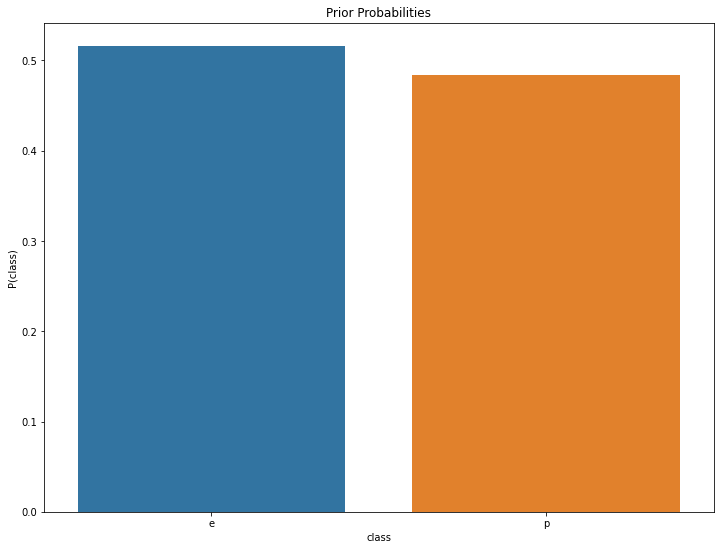

In [52]:
priors = train_df.groupby('class').size() / len(train_df)
ax = sns.barplot(x=priors.index, y=priors)
ax.set_title('Prior Probabilities')
ax.set_xlabel('class')
ax.set_ylabel('P(class)');

Next we sift through each feature and compute $P( feature | class )$. This can be computed from 

$$
\frac{P( feature\ \&\ Class )}{P( Class )}
$$

Again, $P( Class )$ is our initial prior, the overall probability of each class, while $P( feature \&\ Class )$ is the probability that a datapoint with feature $feature$ and class $Class$ appears in the dataset. Again this can be computed by counting the number of instances of each feature/class pair and normalizing by the number of instances of each class.

We create a dictionary containing the likelihood tables for each feature

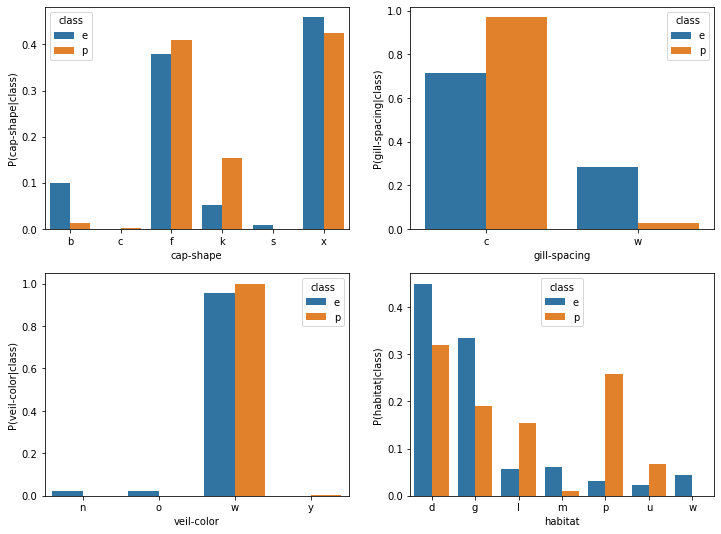

In [65]:
likelihoods = {
    column: train_df.groupby([column, 'class']).size() / train_df.groupby('class').size()
    for column in train_df.columns if column != 'class'
}
plt.figure()
to_plot = ['cap-shape', 'gill-spacing', 'veil-color', 'habitat']
for index, column in enumerate(to_plot):
    table = likelihoods[column].reset_index()
    plt.subplot(2,2,index+1)
    ax = sns.barplot(x=column, y=0, hue='class', data=table)
    ax.set_xlabel(column)
    ax.set_ylabel('P('+column+'|class)')

## Creating Classifier

With this information, we can create our classifier function. This takes a single sample and runs through each feature, updating the probability.

In [113]:
def naive_bayes_classify(sample):
    """
    Determine wether a mushroom sample is
    poisionous or not given it's features
    
    :param sample: single row of a dataset
    :param probs: if true, return normalized probabilities
    
    :return: predicted class
    """
    # Start with a prior probability
    probability = priors.copy()
    
    # For each column with known likelihood table
    # Update our label probabilities using new likelihood
    for column, table in likelihoods.items():
        probability *= table[sample[column]].reindex_like(probability).fillna(0)
        
    # Return class prediction
    return probability.idxmax()

We can test the accuracy of our model using our split test dataset. This is theoretically data that the model has not seen before. We compare the computed classes with the expected classes in the test dataset, and determine the percentage of classes that were predicted correctly.

In [86]:
expected = test_df['class']
actual = test_df.drop('class', axis=1).apply(naive_bayes_classify, axis=1)
accuracy = (expected == actual).sum() / len(test_df)
print('Model Accuracy: {:0.2%}'.format(accuracy))

Model Accuracy: 99.75%


## Making Predictions

Finally let's use this model to make predictions, I have created a little tool to allow for inputting your own data and measuring the output. It's not interactive on the website, however.

And yes I did code all this by hand and no I don't recommend it...

In [114]:
@interact
def custom_classify(
    cap_shape = [
        ('Bell', 'b'),
        ('Conical', 'c'),
        ('Convex', 'x'),
        ('Flat', 'f'),
        ('Knobbed', 'k'),
        ('Sunken', 's')
    ],
    cap_surface = [
        ('Fiberous', 'f'),
        ('Grooves', 'g'),
        ('Scaly', 'y'),
        ('Smooth', 's')
    ],
    cap_color = [
        ('Brown', 'n'),
        ('Buff', 'b'),
        ('Cinnamon', 'c'),
        ('Gray', 'g'),
        ('Green', 'r'),
        ('Pink', 'p'),
        ('Purple', 'u'),
        ('Red', 'e'),
        ('White', 'w'),
        ('Yellow', 'y')
    ],
    bruises = [
        ('Bruises', 't'),
        ('No Bruises', 'f')
    ],
    odor = [
        ('Almond', 'a'),
        ('Anise', 'l'),
        ('Creosote', 'c'),
        ('Fishy', 'y'),
        ('Foul', 'f'),
        ('Musty', 'm'),
        ('None', 'n'),
        ('Pungent', 'p'),
        ('Spicy', 's')
    ],
    gill_attachment = [
        ('Attached', 'a'),
        ('Free', 'f')
    ],
    gill_spacing = [
        ('Close', 'c'),
        ('Crowded', 'w')
    ],
    gill_size = [
        ('Broad', 'b'),
        ('Narrow', 'n')
    ],
    gill_color = [
        ('Black', 'k'),
        ('Brown', 'n'),
        ('Buff', 'b'),
        ('Chocolate', 'h'),
        ('Gray', 'g'),
        ('Green', 'r'),
        ('Orange', 'o'),
        ('Pink', 'p'),
        ('Purple', 'u'),
        ('Red', 'e'),
        ('White', 'w'),
        ('Yellow', 'y')
    ],
    stalk_shape = [
        ('Enlarging', 'e'),
        ('Tapering', 't')
    ],
    stalk_root = [
        ('Bulbous', 'b'),
        ('Club', 'c'),
        ('Cup', 'u'),
        ('Equal', 'e'),
        ('Rhizomorphs', 'z'),
        ('Rooted', 'r'),
        ('Missing', '?')
    ],
    stalk_surface_above_ring = [
        ('Fiberous', 'f'),
        ('Scaly', 'y'),
        ('Silky', 'k'),
        ('Smooth', 's'),
    ],
    stalk_surface_below_ring = [
        ('Fiberous', 'f'),
        ('Scaly', 'y'),
        ('Silky', 'k'),
        ('Smooth', 's'),
    ],
    stalk_color_above_ring = [
        ('Brown', 'n'),
        ('Buff', 'b'),
        ('Cinnamon', 'c'),
        ('Gray', 'g'),
        ('Orange', 'o'),
        ('Pink', 'p'),
        ('Red', 'e'),
        ('White', 'w'),
        ('Yellow', 'y')
    ],
    stalk_color_below_ring = [
        ('Brown', 'n'),
        ('Buff', 'b'),
        ('Cinnamon', 'c'),
        ('Gray', 'g'),
        ('Orange', 'o'),
        ('Pink', 'p'),
        ('Red', 'e'),
        ('White', 'w'),
        ('Yellow', 'y')
    ],
    veil_color = [
        ('Brown', 'n'),
        ('Orange', 'o'),
        ('White', 'w'),
        ('Yellow', 'y')
    ],
    ring_number = [
        ('None', 'n'),
        ('One', 'o'),
        ('Two', 't')
    ],
    ring_type = [
        ('Evanescent', 'e'),
        ('Flaring', 'f'),
        ('Large', 'l'),
        ('None', 'n'),
        ('Pendant', 'p'),
        ('Sheathing', 's'),
        ('Zone', 'z')
    ],
    spore_print_color = [
        ('Black', 'k'),
        ('Brown', 'n'),
        ('Buff', 'b'),
        ('Chocolate', 'h'),
        ('Green', 'r'),
        ('Orange', 'o'),
        ('Purple', 'u'),
        ('White', 'w'),
        ('Yellow', 'y')
    ],
    population = [
        ('Abundant', 'a'),
        ('Clustered', 'c'),
        ('Numerous', 'n'),
        ('Scattered', 's'),
        ('Several', 'v'),
        ('Solitary', 'y')
    ],
    habitat = [
        ('Grasses', 'g'),
        ('Leaves', 'l'),
        ('Meadows', 'm'),
        ('Paths', 'p'),
        ('Urban', 'u'),
        ('Waste', 'w'),
        ('Woods', 'd')
    ]):
    
    # Set up features dict
    features = {
        'cap-shape': cap_shape,
        'cap-surface': cap_surface,
        'cap-color': cap_color,
        'bruises': bruises,
        'odor': odor,
        'gill-attachment': gill_attachment,
        'gill-spacing': gill_spacing,
        'gill-size': gill_size,
        'gill-color': gill_color,
        'stalk-shape': stalk_shape,
        'stalk-root': stalk_root,
        'stalk-surface-above-ring': stalk_surface_above_ring,
        'stalk-surface-below-ring': stalk_surface_below_ring,
        'stalk-color-above-ring': stalk_color_above_ring,
        'stalk-color-below-ring': stalk_color_below_ring,
        'veil-type': 'p',
        'veil-color': veil_color,
        'ring-number': ring_number,
        'ring-type': ring_type,
        'spore-print-color': spore_print_color,
        'population': population,
        'habitat': habitat
    }
    
    # Return class prediction
    klass = naive_bayes_classify(features)
    print('Most Likely class:', klass)

interactive(children=(Dropdown(description='cap_shape', options=(('Bell', 'b'), ('Conical', 'c'), ('Convex', '…

So it looks like most mushroom types appear to be edible (which is fortunate for us). Let's use our generated statistics to try and find the kind of mushroom that's most likely poisionous

In [115]:
for column, table in likelihoods.items():
    print(column, table[:,'p'].idxmax(), sep=': ')

cap-shape: x
cap-surface: y
cap-color: n
bruises: f
odor: f
gill-attachment: f
gill-spacing: c
gill-size: n
gill-color: b
stalk-shape: t
stalk-root: b
stalk-surface-above-ring: k
stalk-surface-below-ring: k
stalk-color-above-ring: w
stalk-color-below-ring: w
veil-type: p
veil-color: w
ring-number: o
ring-type: e
spore-print-color: w
population: v
habitat: d


## Conclusion

So the only improvements I would make for this model should be getting a better dataset, as this one seems very skewed by the looks of it. There are plenty of features that don't have datapoints for a given outcome, and that makes prediction more difficult. I would also look into feature selection. Instead of looking at all the columns, I'd select the columns that provide the most information about the mushroom in question and have the most variety and diversity of data.

That being said, I'm still going to use this dataset because it's the one benchmark I have for testing out data science models